In [310]:
!pip install yellowbrick

     -------------------------------------- 274.2/274.2 kB 2.1 MB/s eta 0:00:00


In [311]:
import os, sys
import glob
import copy
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, plot_confusion_matrix, f1_score, silhouette_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # I like big figures!

In [181]:
# read file
path = r'FE_selected_features'                     # use your path
# all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
# df_from_each_file = (pd.read_csv(f) for f in all_files)

all_files = glob.glob(os.path.join(path , "*.csv"))
li = []
for filename in all_files:
    id = filename.split('dataset_')[1].split('.0_')[0]
    df = pd.read_csv(filename, index_col=0, header=0)
    df['id'] = int(id)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)
df = df.drop(['Unnamed: 0'], axis=1)

act_dict = {'Downstairs': 0,
            'Upstairs': 1,
            'Walking': 2,
            'Jogging': 3,
            'Standing': 4,
            'Sitting': 5}
df['label'] =  df.label.apply(lambda label: act_dict[label])
df.drop(columns=['labelcheck', 'labelcompute'], inplace=True)
df.fillna(0, inplace=True)
df.head()

,acc_userAcceleration.x,acc_userAcceleration.y,att_attitude.roll,gra_gravity.x,gra_gravity.z,rot_rotationRate.x,rot_rotationRate.z,labellabelDownstairs,labellabelUpstairs,labellabelSitting,...,acc_userAcceleration.x_freq_75.0_Hz_ws_40,gra_gravity.x_pse,mag_acc,mag_att,mag_gra,mag_rot,labelcheck,labelcompute,label,id
0,0.120394,0.073186,1.485272,0.759032,-0.065309,0.271613,0.246186,1,0,0,...,NaN,NaN,0.158767,1.773834,0.999518,0.406739,1,1,0,0
1,0.158282,0.029078,1.383779,0.577316,-0.108405,-0.528543,0.026445,1,0,0,...,NaN,NaN,0.163537,1.955130,1.003875,1.178443,1,1,0,0
2,0.165223,-0.087488,1.533631,0.647822,-0.026788,0.387711,0.185151,1,0,0,...,NaN,NaN,0.206415,2.982116,0.998698,0.536272,1,1,0,0
3,0.242239,-0.124033,1.439122,0.616566,-0.095656,-1.052592,0.942906,1,0,0,...,-0.197392,0.0,0.299079,2.040894,0.986333,2.767121,1,1,0,0
4,-0.026037,0.129787,1.285698,0.862960,-0.256881,0.029200,0.267611,1,0,0,...,0.082588,0.0,0.185384,1.480323,0.983567,1.614579,1,1,0,0


In [182]:
check = 'labellabel'
sub = '_label'
cols = df.columns.tolist()
cols = [i.split(check)[1] + sub if check in i else i for i in cols]
labels = [i for i in cols if sub in i]
df.columns = cols

In [137]:
df.columns

Index(['acc_userAcceleration.x', 'acc_userAcceleration.y', 'att_attitude.roll',
       'gra_gravity.x', 'gra_gravity.z', 'rot_rotationRate.x',
       'rot_rotationRate.z', 'Downstairs_label', 'Upstairs_label',
       'Sitting_label', 'Standing_label', 'Walking_label', 'Jogging_label',
       'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7',
       'acc_userAcceleration.y_temp_std_ws_30',
       'acc_userAcceleration.y_temp_median_ws_30',
       'att_attitude.roll_temp_median_ws_30',
       'att_attitude.roll_temp_median_ws_30.1', 'pca_6_temp_std_ws_30',
       'gra_gravity.z_temp_median_ws_30', 'pca_4_temp_std_ws_30',
       'rot_rotationRate.x_temp_std_ws_30',
       'rot_rotationRate.z_temp_std_ws_30', 'rot_rotationRate.z_freq_weighted',
       'att_attitude.yaw_pse', 'rot_rotationRate.x_freq_75.0_Hz_ws_40',
       'acc_userAcceleration.x_freq_75.0_Hz_ws_40', 'gra_gravity.x_pse',
       'mag_acc', 'mag_att', 'mag_gra', 'mag_rot', 'labelcheck',
       'labelcompute', 'label', 'id'],
      

In [133]:
# decide which person's data are taken out to test set
flag = True
while flag:
    index = np.round(np.random.random((3,1))*23).astype(int)
    mask = np.unique(index)
    print(mask.shape[0])
    if mask.shape[0] == 3:
        flag = False
index = index.squeeze().tolist()
print(index)

3
[14, 22, 11]


In [265]:
# split all dataset into subset, we have 24 subjects data, we separate 3 subjects' all data into test1.csv
# split data of 6 labels from each of the rest 21 subjects' data and sample them using 8:2 ratio into test2.csv 
# the rest is the training dataset
def train_test_spl(df_all, fname, index):
    df_test1 = df_all[df_all.id.isin(index)].reset_index(drop=True)
    df_train = df_all[~df_all.id.isin(index)]
    print(f'all:{df_all.shape}, train 1: {df_train.shape}, test 1: {df_test1.shape}')

    test = []
    for i in df_train.id.unique():
        df_subtrain = df_train[df_train.id == i]
        for j in labels:
            df_subsub = df_subtrain[df_subtrain[j] == 1]
            df_subtest = df_subsub.sample(frac=0.2)
            test.append(df_subtest)
    df_test2 = pd.concat(test, axis=0, ignore_index=False)
    df_train = df_train[~df_train.index.isin(df_test2.index)]
    print(df_train.id.nunique(), df_test2.id.nunique())
    print(f'all:{df_all.shape}, train 2: {df_train.shape}, test 2: {df_test2.shape}')
    df_train, df_test2 = df_train.reset_index(drop=True), df_test2.reset_index(drop=True)
    df_train.to_csv(f'{fname}/train.csv', index=False)
    df_test1.to_csv(f'{fname}/test1.csv', index=False)
    df_test2.to_csv(f'{fname}/test2.csv', index=False)
    return df_train, df_test1, df_test2

## feature selection based on mutual information and correlation
def feature_selection(feature_frame, label):
    mutualInfo = mutual_info_regression(feature_frame, label, discrete_features='auto')
    mutualInfo_select = pd.Series(data = mutualInfo , index = feature_frame.columns).sort_values(ascending = False)
    feature_frame.insert(len(feature_frame.columns),'label',label)#再添加一列
    corr = feature_frame.corr()
    corr_series = pd.Series(data = corr.iloc[-1,:-1])
    corr_sort = corr_series.abs().sort_values(ascending = False)
    plt.figure(figsize=(20,10))
    sns.barplot(mutualInfo_select.values[:10], mutualInfo_select.index[:10], orient='h')
    plt.title("Correlation screening based on mutual information")
    plt.savefig('images/feature_mutual_info.png')
    plt.show()

    plt.figure(figsize=(20,10))
    sns.barplot(corr_sort.values[:10], corr_sort.index[:10], orient='h')
    plt.title("Correlation screening based on correlation coefficient")
    plt.savefig('images/feature_corrlation.png')
    plt.show()
    return mutualInfo_select.index[:10].to_list(), corr_sort.index[:10].to_list()

# backward selection
def backward_selection(max_features, X_train, y_train):
    # First select all features.
    selected_features = X_train.columns.tolist()
    tree = DecisionTreeClassifier(min_samples_leaf=23, criterion='gini')

    # Select from the features that are still in the selection.
    for i in range(0, (len(X_train.columns) - max_features)):
        worst_perf = np.inf
        worst_feature = ''
        # Select from the features that are still in the selection.
        for f in selected_features:
            temp_selected_features = copy.deepcopy(selected_features)
            temp_selected_features.remove(f)

            tree.fit(X_train[temp_selected_features], y_train.values.ravel())
            # Determine the score without the feature.
            pred_y_train = tree.predict(X_train[temp_selected_features])
            perf = accuracy_score(y_train, pred_y_train)
            # If we score better (i.e. a lower mse) without the feature than what we have seen so far
            # this is the worst feature.

            if perf < worst_perf:
                worst_perf = perf
                worst_feature = f

        # Remove the worst feature.
        selected_features.remove(worst_feature)
    return selected_features

In [322]:
# separate dataset
df_train, df_test1, df_test2 = train_test_spl(df, 'data_initial', index)

all:(10085, 38), train 1: (8889, 38), test 1: (1196, 38)
21 21
all:(10085, 38), train 2: (7118, 38), test 2: (1771, 38)


In [156]:
df.label.value_counts()

Walking       2457
Sitting       2420
Standing      2181
Upstairs      1117
Jogging        960
Downstairs     950
Name: label, dtype: int64

c:\Users\HHhou\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


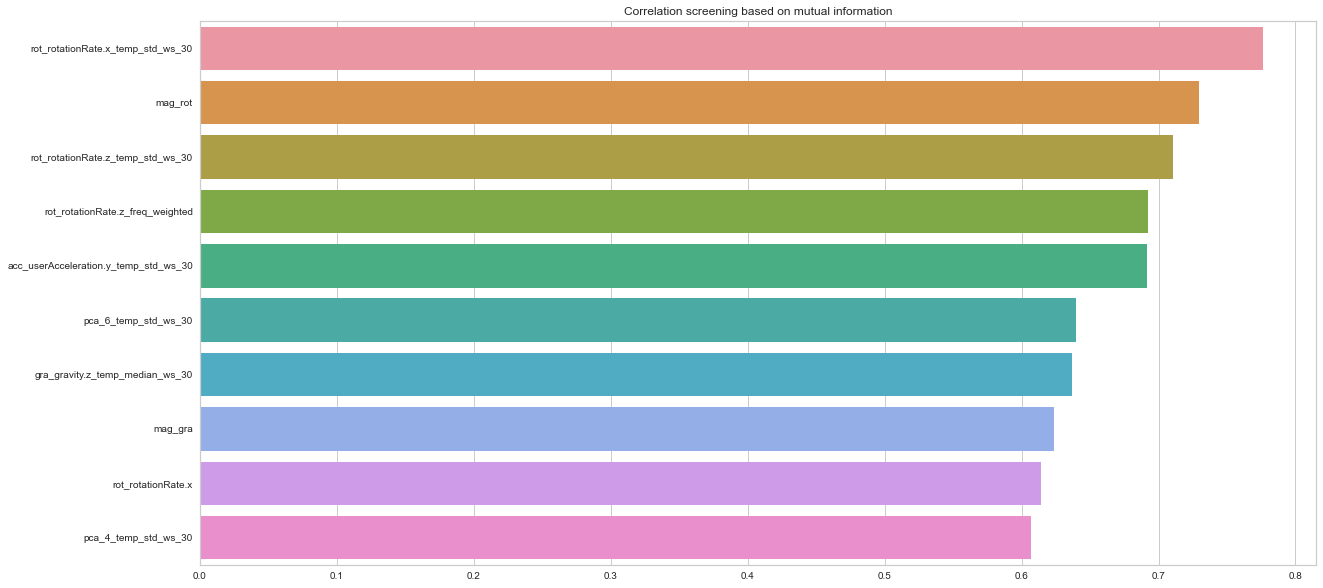

c:\Users\HHhou\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


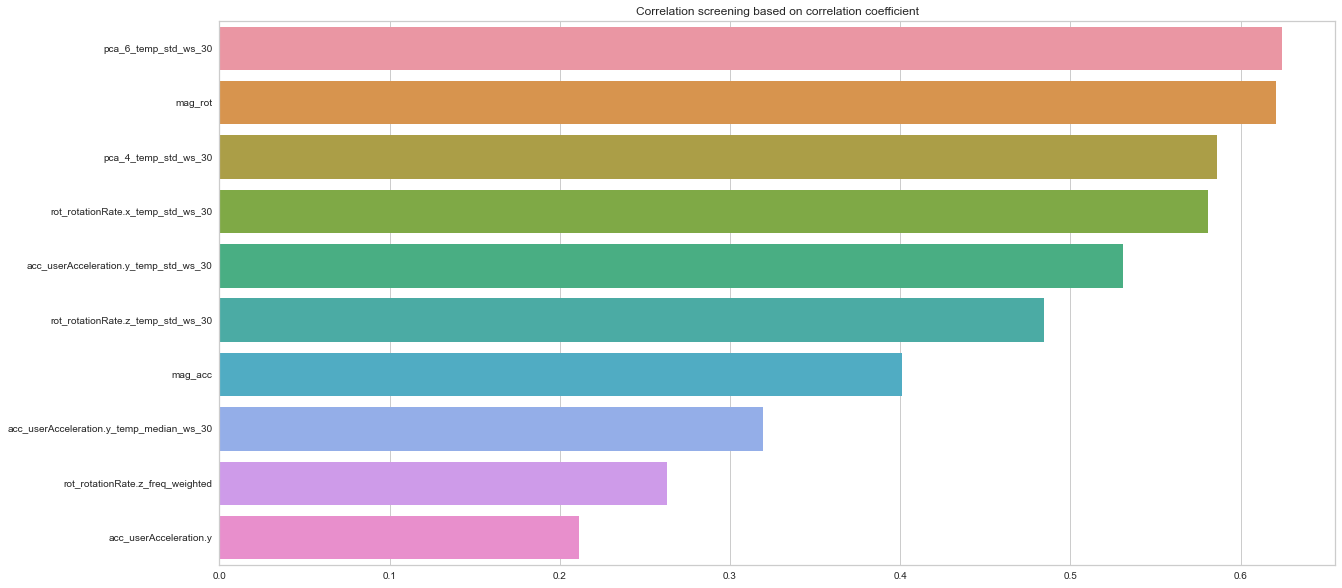

['rot_rotationRate.z_temp_std_ws_30', 'mag_rot', 'mag_gra', 'acc_userAcceleration.y_temp_median_ws_30', 'pca_6_temp_std_ws_30', 'rot_rotationRate.z_freq_weighted', 'pca_4_temp_std_ws_30', 'rot_rotationRate.x', 'gra_gravity.z_temp_median_ws_30', 'acc_userAcceleration.y_temp_std_ws_30', 'rot_rotationRate.x_temp_std_ws_30', 'acc_userAcceleration.y', 'mag_acc']
['id', 'pca_6_temp_std_ws_30', 'rot_rotationRate.z_freq_weighted', 'pca_4_temp_std_ws_30', 'rot_rotationRate.z_temp_std_ws_30', 'rot_rotationRate.x_temp_std_ws_30', 'acc_userAcceleration.y_temp_std_ws_30', 'mag_rot']


In [328]:
# feature selection
df_train.drop(columns=labels, inplace=True)
df_test1.drop(columns=labels, inplace=True)
df_test2.drop(columns=labels, inplace=True)

X, y = df_train.iloc[:,:-2], df_train.iloc[:,-2]
feat_list1, feat_list2 = feature_selection(X, y)
feat_list = list(set(feat_list1).union(set(feat_list2)))
print(feat_list)
cluster1_feat =  list(set(feat_list1).intersection(set(feat_list2)))
cluster1_feat.insert(0, 'id')
print(cluster1_feat)

In [335]:
def analysis_cluster_labels(labels):
    count = []
    for i in range(max(labels)+1):
        count.append((labels == i).sum())
    print(f' len: {len(count)}, max: {max(count)}, min: {min(count)}, mean: {int(np.mean(count))}, median: {np.median(count)}')

def plot_silhouette(df):
    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in [2, 3, 4, 5]:
        '''
        Create KMeans instance for different number of clusters
        '''
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
        q, mod = divmod(i, 2)
        '''
        Create SilhouetteVisualizer instance with KMeans instance
        Fit the visualizer
        '''
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(df)

def scala_data(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    df_usr_scaled = scaler.transform(df)
    return df_usr_scaled, scaler


Cluster user:
[1 1 0 1 0 1 0 0 1 2 1 1 1 2 1 0 0 1 1 1 2]
 len: 3, max: 12, min: 3, mean: 7, median: 6.0
Silhouetter Score: 0.328
(7118, 33) Index(['acc_userAcceleration.x', 'acc_userAcceleration.y', 'att_attitude.roll',
       'gra_gravity.x', 'gra_gravity.z', 'rot_rotationRate.x',
       'rot_rotationRate.z', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7',
       'acc_userAcceleration.y_temp_std_ws_30',
       'acc_userAcceleration.y_temp_median_ws_30',
       'att_attitude.roll_temp_median_ws_30',
       'att_attitude.roll_temp_median_ws_30.1', 'pca_6_temp_std_ws_30',
       'gra_gravity.z_temp_median_ws_30', 'pca_4_temp_std_ws_30',
       'rot_rotationRate.x_temp_std_ws_30',
       'rot_rotationRate.z_temp_std_ws_30', 'rot_rotationRate.z_freq_weighted',
       'att_attitude.yaw_pse', 'rot_rotationRate.x_freq_75.0_Hz_ws_40',
       'acc_userAcceleration.x_freq_75.0_Hz_ws_40', 'gra_gravity.x_pse',
       'mag_acc', 'mag_att', 'mag_gra', 'mag_rot', 'label', 'id',
       'usr_cluster'],
 

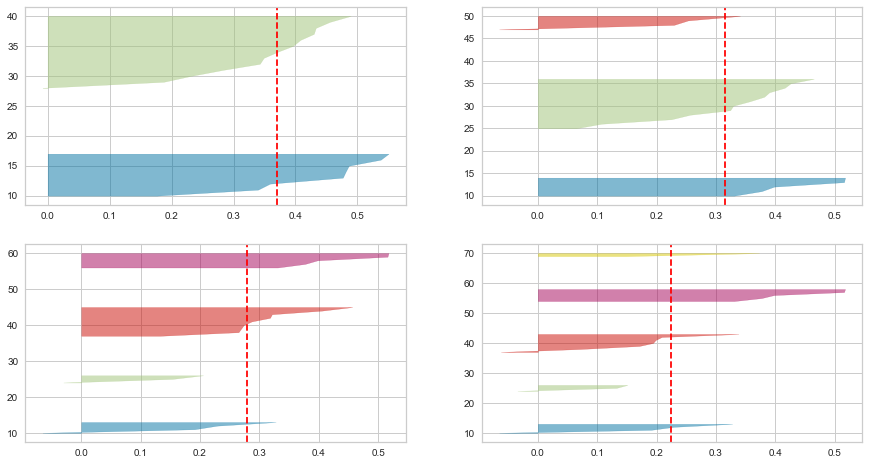

In [353]:
dss = pd.read_csv("data_subjects_info.csv").drop(columns=['code'])
df_train_usr = df_train[cluster1_feat].join(dss, on='id', how='left')
df_train_usr = df_train_usr.groupby('id').agg('mean')
usr_id = df_train_usr.index.to_numpy()
df_usr_scaled, scaler = scala_data(df_train_usr)
plot_silhouette(df_usr_scaled)

kmeans1 = KMeans(n_clusters=3)
kmeans1.fit(df_usr_scaled)

print(f"Cluster user:\n{kmeans1.labels_}")

analysis_cluster_labels(kmeans1.labels_)

score = silhouette_score(df_usr_scaled, kmeans1.labels_, metric='euclidean')
# Print the score
print('Silhouetter Score: %.3f' % score)

cluster_array_1 = np.hstack((usr_id.reshape(-1,1), kmeans1.labels_.reshape(-1,1)))
df_usr_cluster = pd.DataFrame(cluster_array_1, columns = ['id', 'usr_cluster']).astype({"id":"int64","usr_cluster":"int64"})
df_usr_clustered = pd.merge(df_train, df_usr_cluster, on='id')
print(df_usr_clustered.shape, df_usr_clustered.columns)

In [354]:
feat_list3 = backward_selection(10, df_usr_clustered.drop(columns=['id', 'label']), df_usr_clustered.iloc[:, -3])
feat_list3

['rot_rotationRate.x',
 'rot_rotationRate.z',
 'pca_4',
 'pca_5',
 'pca_6',
 'pca_7',
 'att_attitude.roll_temp_median_ws_30',
 'att_attitude.roll_temp_median_ws_30.1',
 'rot_rotationRate.x_freq_75.0_Hz_ws_40',
 'usr_cluster']

In [332]:
list(set(feat_list).intersection(set(feat_list3)))

['mag_acc', 'acc_userAcceleration.y', 'rot_rotationRate.x', 'mag_gra']

In [474]:
def predict_cluster1(df_test, df_train, scaler, km):
    if df_test.id.nunique() == df_train.id.nunique():
        df_usr_label = df_train[['id', 'usr_cluster']].groupby('id').agg('median')
        df_test = df_test.join(df_usr_label, on='id', how='left')
    else:
        df_test_usr = df_test[cluster1_feat].join(dss, on='id', how='left')
        df_test_usr = df_test_usr.groupby('id').agg('mean')
        usr_id = df_test_usr.index.to_numpy()
        df_usr_scaled = scaler.transform(df_test_usr)
        labels = km.predict(df_usr_scaled)
        cluster_array = np.hstack((usr_id.reshape(-1,1), labels.reshape(-1,1)))
        df_usr_cluster = pd.DataFrame(cluster_array, columns = ['id', 'usr_cluster']).astype({"id":"int64","usr_cluster":"int64"})
        df_test = pd.merge(df_test, df_usr_cluster, on='id')
    return df_test

def predict_cluster2(df_test, scaler, km):
    dtp_id = df_test.index.to_numpy()
    df_scaled = scaler.transform(df_test.iloc[:, :-1])
    labels = km.predict(df_scaled)
    cluster_array = np.hstack((dtp_id.reshape(-1,1), labels.reshape(-1,1)))
    df_cluster = pd.DataFrame(cluster_array, columns = ['dtp_id', 'dtp_cluster']).astype({"dtp_id":"int64","dtp_cluster":"int64"})
    df_test['dtp_id'] = dtp_id

    df_test = pd.merge(df_test, df_cluster, on='dtp_id', how='left')
    print(df_test.shape, df_test.columns)
    return df_test


In [376]:
df_test1 = predict_cluster1(df_test1, df_usr_clustered, scaler, kmeans1)
df_test2 = predict_cluster1(df_test2, df_usr_clustered, scaler, kmeans1)
feat_list3.append('label')
fname = 'data_selected'
df_usr_clustered[feat_list3].to_csv(f'{fname}/train.csv', index=False)
df_test1[feat_list3].to_csv(f'{fname}/test1.csv', index=False)
df_test2[feat_list3].to_csv(f'{fname}/test2.csv', index=False)

In [404]:
all_feat = list(set(feat_list3).union(set(feat_list)))
all_feat.remove('label')
all_feat.append('label')
fname = 'data_selected_21'
df_usr_clustered[all_feat].to_csv(f'{fname}/train.csv', index=False)
df_test1[all_feat].to_csv(f'{fname}/test1.csv', index=False)
df_test2[all_feat].to_csv(f'{fname}/test2.csv', index=False)

<AxesSubplot:xlabel='k', ylabel='silhouette_score'>

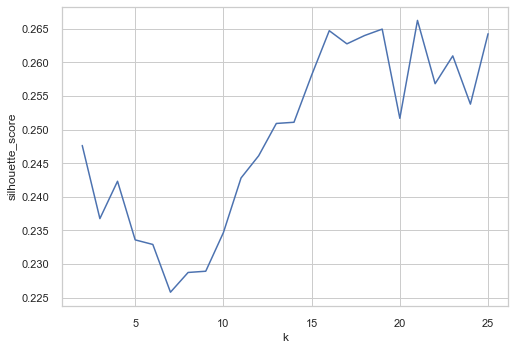

In [445]:
df_usr_clustered2 = df_usr_clustered[all_feat].iloc[:,:-1]
df_usr_clustered_scaled, scaler = scala_data(df_usr_clustered2)
n = [i for i in range(2,26)]
scores = []
for i in n:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    km.fit(df_usr_clustered_scaled)
    score = silhouette_score(df_usr_clustered_scaled, km.labels_, metric='euclidean')
    scores.append(score)
silhouette = pd.DataFrame(list(zip(n, scores)), columns =['k', 'silhouette_score'])
sns.set_theme(style="whitegrid")
sns.lineplot(data=silhouette, x='k', y='silhouette_score')

Cluster user:
[ 0  0  6 ... 14 14 14]
 len: 18, max: 698, min: 73, mean: 395, median: 395.5
Silhouetter Score: 0.262
(7118, 24) Index(['rot_rotationRate.z_temp_std_ws_30', 'mag_rot', 'mag_gra', 'pca_6',
       'acc_userAcceleration.y_temp_median_ws_30', 'usr_cluster',
       'pca_6_temp_std_ws_30', 'rot_rotationRate.z', 'pca_4',
       'rot_rotationRate.x_freq_75.0_Hz_ws_40', 'rot_rotationRate.x',
       'rot_rotationRate.z_freq_weighted', 'pca_4_temp_std_ws_30',
       'gra_gravity.z_temp_median_ws_30', 'pca_5',
       'acc_userAcceleration.y_temp_std_ws_30',
       'att_attitude.roll_temp_median_ws_30.1',
       'rot_rotationRate.x_temp_std_ws_30', 'acc_userAcceleration.y',
       'att_attitude.roll_temp_median_ws_30', 'pca_7', 'mag_acc', 'dtp_id',
       'dtp_cluster'],
      dtype='object')


c:\Users\HHhou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\HHhou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 't-SNE feature 1')

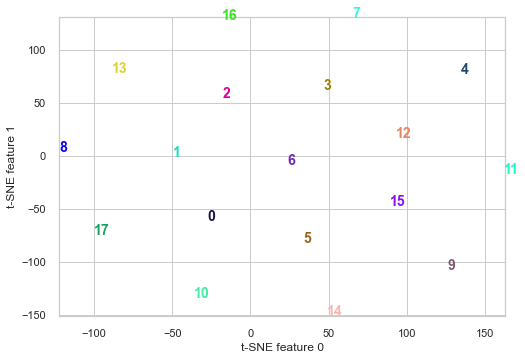

In [463]:
kmeans2 = KMeans(n_clusters=18)
kmeans2.fit(df_usr_clustered_scaled)

print(f"Cluster user:\n{kmeans2.labels_}")

analysis_cluster_labels(kmeans2.labels_)

score = silhouette_score(df_usr_clustered_scaled, kmeans2.labels_, metric='euclidean')
# Print the score
print('Silhouetter Score: %.3f' % score)

dtp_id = df_usr_clustered2.index.to_numpy()
df_usr_clustered2['dtp_id'] = dtp_id
cluster_array_2 = np.hstack((dtp_id.reshape(-1,1), kmeans2.labels_.reshape(-1,1)))
df_cluster = pd.DataFrame(cluster_array_2, columns = ['dtp_id', 'dtp_cluster']).astype({"dtp_id":"int64","dtp_cluster":"int64"})
df_clustered = pd.merge(df_usr_clustered2, df_cluster, on='dtp_id', how='left')
print(df_clustered.shape, df_clustered.columns)

# plot kmeans center
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(kmeans2.cluster_centers_)

plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max()+1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max()+1)
for i in range(len(kmeans2.cluster_centers_)):
    plt.text(digits_tsne[i,0], digits_tsne[i,1], str((range(len(kmeans2.cluster_centers_)))[i]),
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]),
        fontdict={'weight':'bold', 'size':14})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

c:\Users\HHhou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\HHhou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 't-SNE feature 1')

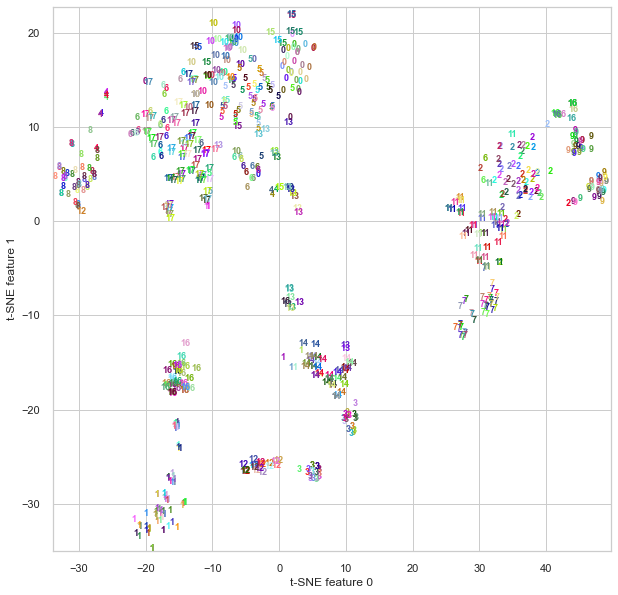

In [458]:
#sample
def sample(feature, label):
    index = list(range(len(feature)))
    sample_idx = np.random.choice(index, round(len(index)/10), replace=False)
    sample_feature = feature[sample_idx]
    sample_label = label[sample_idx]
    return sample_feature, sample_label

sample_feature, sample_label = sample(df_usr_clustered_scaled, kmeans2.labels_)
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(sample_feature)

plt.figure(figsize=(10,10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max()+1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max()+1)
for i in range(len(sample_feature)):
    plt.text(digits_tsne[i,0], digits_tsne[i,1], str(sample_label[i]),
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]),
        fontdict={'weight':'bold', 'size':9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

In [475]:
df_test1_clustered = predict_cluster2(df_test1[all_feat], scaler, kmeans2)
df_test1_clustered

C:\Users\HHhou\AppData\Local\Temp\ipykernel_12468\1995281177.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['dtp_id'] = dtp_id
c:\Users\HHhou\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- label
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 23 features, but MinMaxScaler is expecting 22 features as input.

In [477]:
df_test1[all_feat].iloc[:,:-1]

,rot_rotationRate.z_temp_std_ws_30,mag_rot,mag_gra,pca_6,acc_userAcceleration.y_temp_median_ws_30,usr_cluster,pca_6_temp_std_ws_30,rot_rotationRate.z,pca_4,rot_rotationRate.x_freq_75.0_Hz_ws_40,...,pca_4_temp_std_ws_30,gra_gravity.z_temp_median_ws_30,pca_5,acc_userAcceleration.y_temp_std_ws_30,att_attitude.roll_temp_median_ws_30.1,rot_rotationRate.x_temp_std_ws_30,acc_userAcceleration.y,att_attitude.roll_temp_median_ws_30,pca_7,mag_acc
0,0.000000,2.120099,0.989202,-0.101550,0.000000,1,0.000000,-0.319042,-0.150696,0.000000,...,0.000000,0.000000,-0.134716,0.000000,0.000000,0.000000,-0.301017,0.000000,0.266676,0.450611
1,0.000000,0.375545,0.994913,-0.048352,0.000000,1,0.000000,0.251616,0.084138,0.000000,...,0.000000,0.000000,-0.174936,0.000000,0.000000,0.000000,0.132892,0.000000,-0.041136,0.200643
2,0.000000,0.893865,0.990157,0.030190,0.000000,1,0.000000,-0.178713,0.081659,0.000000,...,0.000000,0.000000,-0.192731,0.000000,0.000000,0.000000,0.095723,0.000000,0.022158,0.187318
3,0.330055,0.244537,0.992925,-0.015742,0.090006,1,0.090648,0.101132,-0.089859,-1.016897,...,0.109905,-0.176435,0.055922,0.141902,-1.010542,0.839429,0.048346,-1.010542,-0.022457,0.088087
4,0.305175,0.854548,0.989299,0.214925,0.075705,1,0.083967,-0.033580,0.146544,-1.313035,...,0.112827,-0.196953,-0.105363,0.129494,-0.919654,0.778154,0.247056,-0.919654,0.009482,0.410667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.665097,2.513700,0.941088,0.035594,0.108537,2,0.078295,0.921708,-0.055848,0.131625,...,0.135033,-0.354670,0.207081,0.129555,0.388677,1.251506,0.166356,0.388677,-0.004656,0.245992
1192,0.674520,2.123904,1.003439,-0.316639,0.110185,2,0.093112,1.397534,0.138461,1.103971,...,0.145663,-0.357397,-0.333466,0.141491,0.414879,1.254019,-0.063207,0.414879,-0.254533,0.243976
1193,0.657669,1.310819,0.951283,0.169203,0.112232,2,0.104762,-0.660638,-0.052521,0.758666,...,0.168117,-0.334489,-0.070496,0.157900,0.297510,1.248962,0.247089,0.297510,-0.014218,0.394198
1194,0.656624,1.707208,0.952112,0.065654,0.114561,2,0.105798,-1.220677,0.214544,-1.801507,...,0.176842,-0.303990,-0.086346,0.161507,0.246442,1.236963,0.097728,0.246442,-0.023642,0.221996


In [468]:
df_clustered

,rot_rotationRate.z_temp_std_ws_30,mag_rot,mag_gra,pca_6,acc_userAcceleration.y_temp_median_ws_30,usr_cluster,pca_6_temp_std_ws_30,rot_rotationRate.z,pca_4,rot_rotationRate.x_freq_75.0_Hz_ws_40,...,pca_5,acc_userAcceleration.y_temp_std_ws_30,att_attitude.roll_temp_median_ws_30.1,rot_rotationRate.x_temp_std_ws_30,acc_userAcceleration.y,att_attitude.roll_temp_median_ws_30,pca_7,mag_acc,dtp_id,dtp_cluster
count,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,...,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000,7118.000000
mean,0.325579,0.768957,0.996155,-0.000182,0.040724,0.843355,0.060495,0.009658,0.000794,0.011936,...,-0.000872,0.064454,-0.160981,0.591617,0.043602,-0.160981,0.000651,0.136613,3558.500000,7.963613
std,0.370422,0.877337,0.015938,0.097236,0.072930,0.644727,0.050648,0.501323,0.162366,0.925237,...,0.134574,0.068964,1.373579,0.588291,0.122322,1.373579,0.081891,0.183039,2054.933941,5.150995
min,0.000000,0.000189,0.872098,-0.395613,-0.183235,0.000000,0.000000,-2.833417,-0.563425,-7.095320,...,-0.579580,0.000000,-3.070734,0.000000,-0.564820,-3.070734,-0.476476,0.000419,0.000000,0.000000
25%,0.022180,0.018676,0.993307,-0.043723,0.003891,0.000000,0.010769,-0.053556,-0.084016,-0.105950,...,-0.075223,0.004258,-1.222468,0.028999,-0.001103,-1.222468,-0.035427,0.017186,1779.250000,4.000000
50%,0.191912,0.410634,0.999989,-0.003225,0.013890,1.000000,0.057592,0.000132,-0.005834,0.000000,...,-0.004051,0.052763,0.121197,0.502067,0.008990,0.121197,-0.001147,0.067388,3558.500000,8.000000
75%,0.537436,1.371182,1.000009,0.040983,0.060318,1.000000,0.096945,0.075313,0.083627,0.108805,...,0.067248,0.099847,0.881935,0.997357,0.074495,0.881935,0.035158,0.195751,5337.750000,12.000000
max,1.949897,4.246349,1.176968,0.577726,0.817748,2.000000,0.290507,2.876232,0.848437,6.401705,...,0.645407,0.406123,3.048464,2.372634,1.212707,3.048464,0.581649,2.013909,7117.000000,17.000000
